# HW 5: Seq2seq with Attention


*   본 실습에서는 sequence to sequence 모델을 구현하고 attention 모듈을 추가합니다.


### Part 1. Seq2seq with toy example

**Part 1.1 데이터 전처리**

In [105]:
from tqdm import tqdm
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn import functional as F

import torch
import random

`src_data`를 `trg_data`로 바꾸는 번역 task를 수행하기 위한 sample data를 준비합니다.

전체 단어 수는 100 개이고 다음과 같이 `pad token`, `start token`, `end token`의 id도 정의합니다.

In [106]:
vocab_size = 100
pad_id = 0
sos_id = 1 # <sos> : start of sentence
eos_id = 2 # <eos> : end of sentnece

src_data = [
  [3, 77, 56, 26, 3, 55, 12, 36, 31],
  [58, 20, 65, 46, 26, 10, 76, 44],
  [58, 17, 8],
  [59],
  [29, 3, 52, 74, 73, 51, 39, 75, 19],
  [41, 55, 77, 21, 52, 92, 97, 69, 54, 14, 93],
  [39, 47, 96, 68, 55, 16, 90, 45, 89, 84, 19, 22, 32, 99, 5],
  [75, 34, 17, 3, 86, 88],
  [63, 39, 5, 35, 67, 56, 68, 89, 55, 66],
  [12, 40, 69, 39, 49]
]

trg_data = [
  [75, 13, 22, 77, 89, 21, 13, 86, 95],
  [79, 14, 91, 41, 32, 79, 88, 34, 8, 68, 32, 77, 58, 7, 9, 87],
  [85, 8, 50, 30],
  [47, 30],
  [8, 85, 87, 77, 47, 21, 23, 98, 83, 4, 47, 97, 40, 43, 70, 8, 65, 71, 69, 88],
  [32, 37, 31, 77, 38, 93, 45, 74, 47, 54, 31, 18],
  [37, 14, 49, 24, 93, 37, 54, 51, 39, 84],
  [16, 98, 68, 57, 55, 46, 66, 85, 18],
  [20, 70, 14, 6, 58, 90, 30, 17, 91, 18, 90],
  [37, 93, 98, 13, 45, 28, 89, 72, 70]
]

In [107]:
# target data 의 각 문장의 시작과 끝에 <sos> token id 와 <eos> token id 를 추가합니다.
trg_data = [[sos_id]+seq+[eos_id] for seq in tqdm(trg_data)]

100%|██████████| 10/10 [00:00<00:00, 88115.63it/s]


In [108]:
# 각 문장의 길이를 동일하게 맞춰주기 위해 <pad> token id 를 추가하는 padding 함수를 정의합니다.
def padding(data):
  max_len = len(max(data, key=len))
  print(f"Maximum sequence length: {max_len}")

  valid_lens = []
  for i, seq in enumerate(tqdm(data)):
    valid_lens.append(len(seq))
    if len(seq) < max_len:
      data[i] = seq + [pad_id] * (max_len - len(seq)) #패딩을 뒤에 더합니다.

  return data, valid_lens, max_len #패딩넣은 데이터셋 , 각 문장의 패딩을 넣기전 단어의 갯수, 패딩넣고 각문장의 단어의 갯수(모든 문장이 같음)

In [109]:
src_data, src_lens, src_max_len = padding(src_data)
trg_data, trg_lens, trg_max_len = padding(trg_data)

Maximum sequence length: 15


100%|██████████| 10/10 [00:00<00:00, 82891.38it/s]


Maximum sequence length: 22


100%|██████████| 10/10 [00:00<00:00, 72817.78it/s]


In [110]:
# B: batch size,  
# S_L: source maximum sequence length, 
# T_L: target maximum sequence length

src_batch = torch.LongTensor(src_data)  # (B, S_L)
src_batch_lens = torch.LongTensor(src_lens)  # (B)
trg_batch = torch.LongTensor(trg_data)  # (B, T_L)
trg_batch_lens = torch.LongTensor(trg_lens)  # (B)

print(src_batch.shape) #출력 : 10,15 . 10은 문장의 갯수. 15는 최대 단어의 갯수. 각 자리에는 단어의 인덱스가 들어가 있음.
print(src_batch_lens.shape) #문장마다 단어의 갯수.

print(src_batch_lens)
print(src_batch)

print(trg_batch.shape)
print(trg_batch_lens.shape)

torch.Size([10, 15])
torch.Size([10])
tensor([ 9,  8,  3,  1,  9, 11, 15,  6, 10,  5])
tensor([[ 3, 77, 56, 26,  3, 55, 12, 36, 31,  0,  0,  0,  0,  0,  0],
        [58, 20, 65, 46, 26, 10, 76, 44,  0,  0,  0,  0,  0,  0,  0],
        [58, 17,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [59,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [29,  3, 52, 74, 73, 51, 39, 75, 19,  0,  0,  0,  0,  0,  0],
        [41, 55, 77, 21, 52, 92, 97, 69, 54, 14, 93,  0,  0,  0,  0],
        [39, 47, 96, 68, 55, 16, 90, 45, 89, 84, 19, 22, 32, 99,  5],
        [75, 34, 17,  3, 86, 88,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [63, 39,  5, 35, 67, 56, 68, 89, 55, 66,  0,  0,  0,  0,  0],
        [12, 40, 69, 39, 49,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
torch.Size([10, 22])
torch.Size([10])


In [111]:
src_batch_lens, sorted_idx = src_batch_lens.sort(descending=True) #실제 단어가 긴것부터 정렬?? trg는?? -> sorted_idx가 있다!!
print(src_batch_lens, sorted_idx)
print("############src_batch_lens, sorted_idx##############")
src_batch = src_batch[sorted_idx] # 소스 길이를 기준으로 내림차순하는 인덱스리스트를 소스와 타겟에 적용. 소스는 내림차순 정렬. 타겟은 서로 소스 쌍에 맞게 위치가 변환됨.
trg_batch = trg_batch[sorted_idx]
trg_batch_lens = trg_batch_lens[sorted_idx] #길이를 저장하는 리스트도 변환해준다.

print(src_batch)
print(src_batch_lens)
print(trg_batch)
print(trg_batch_lens)

tensor([15, 11, 10,  9,  9,  8,  6,  5,  3,  1]) tensor([6, 5, 8, 0, 4, 1, 7, 9, 2, 3])
############src_batch_lens, sorted_idx##############
tensor([[39, 47, 96, 68, 55, 16, 90, 45, 89, 84, 19, 22, 32, 99,  5],
        [41, 55, 77, 21, 52, 92, 97, 69, 54, 14, 93,  0,  0,  0,  0],
        [63, 39,  5, 35, 67, 56, 68, 89, 55, 66,  0,  0,  0,  0,  0],
        [ 3, 77, 56, 26,  3, 55, 12, 36, 31,  0,  0,  0,  0,  0,  0],
        [29,  3, 52, 74, 73, 51, 39, 75, 19,  0,  0,  0,  0,  0,  0],
        [58, 20, 65, 46, 26, 10, 76, 44,  0,  0,  0,  0,  0,  0,  0],
        [75, 34, 17,  3, 86, 88,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [12, 40, 69, 39, 49,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [58, 17,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [59,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
tensor([15, 11, 10,  9,  9,  8,  6,  5,  3,  1])
tensor([[ 1, 37, 14, 49, 24, 93, 37, 54, 51, 39, 84,  2,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
  

**Part 1.2 Encoder 구현**


*   Embedding layer, output layer, GRU cell 을 포함한 encoder 모듈을 구현합니다.



In [112]:
embedding_size = 256
hidden_size = 512
num_layers = 2
num_dirs = 2 # 2 if bidirectional=True otherwise 1
dropout = 0.1

In [113]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_size) 
    self.gru = nn.GRU(
        input_size=embedding_size, 
        hidden_size=hidden_size,
        num_layers=num_layers,
        bidirectional=True if num_dirs > 1 else False,
        dropout=dropout
    )
    self.linear = nn.Linear(num_dirs * hidden_size, hidden_size)

  def forward(self, batch, batch_lens):  # batch: (B, S_L), batch_lens: (B)   #batch <<- src_batch , batch_lens <<- src_batch_lens        #단어 임베딩.  d_w의 차원으로 임베딩.
    # d_w: word embedding size
    batch_emb = self.embedding(batch)  # (B, S_L, d_w)
    batch_emb = batch_emb.transpose(0, 1)  # (S_L, B, d_w)

    packed_input = pack_padded_sequence(batch_emb, batch_lens) #??
    #<https://blog.naver.com/PostView.naver?blogId=ys10mjh&logNo=222215973937&parentCategoryNo=&categoryNo=29&viewDate=&isShowPopularPosts=true&from=search>

    h_0 = torch.zeros((num_layers * num_dirs, batch.shape[0], hidden_size))  # (num_dirs*num_layers, B(문장의갯수), d_h) = (4, B, d_h)   #encoding
    packed_outputs, h_n =self.gru(packed_input,h_0)              ## TO DO ##  # h_n: (4, B, d_h)
    #<https://wiserloner.tistory.com/1314>

    outputs = pad_packed_sequence(packed_outputs)[0]  # outputs: (S_L, B, 2d_h)
    outputs = torch.tanh(self.linear(outputs))  # (S_L, B, d_h) 15 * 10 * 512

    forward_hidden = h_n[-2, :, :] #shape : 문장의 갯수 * hidden_size
    backward_hidden = h_n[-1, :, :]
    hidden = torch.tanh(self.linear(torch.cat((forward_hidden, backward_hidden), dim=-1))).unsqueeze(0)  # (1, B, d_h)
    
    return outputs, hidden

In [114]:
encoder = Encoder()

### **Dot-product Attention 구현**
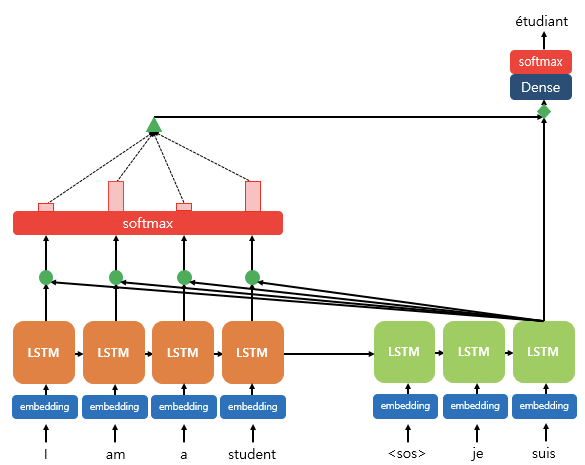

[Dot-product Attention 계산 메커니즘 복습하기](https://wikidocs.net/22893)

우선 대표적인 attention 형태 중 하나인 Dot-product Attention은 다음과 같이 구현할 수 있습니다.



In [115]:
class DotAttention(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, decoder_hidden, encoder_outputs):  # (1, B, d_h), (S_L, B, d_h)
    query = decoder_hidden.squeeze(0)  # (B, d_h)
    key = encoder_outputs.transpose(0, 1)  # (B, S_L, d_h)

    energy = torch.sum(torch.mul(key, query.unsqueeze(1)), dim=-1)  # (B, S_L)

    attn_scores = F.softmax(energy, dim=-1)  # (B, S_L)
    attn_values = torch.sum(torch.mul(encoder_outputs.transpose(0, 1), attn_scores.unsqueeze(2)), dim=1)  # (B, d_h)

    return attn_values, attn_scores

In [116]:
dot_attn = DotAttention()

이제 이 attention 모듈을 가지는 Decoder 클래스를 구현하겠습니다.

In [117]:
class Decoder(nn.Module):
  def __init__(self, attention):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.attention = attention
    self.rnn = nn.GRU(
        embedding_size,
        hidden_size
    )
    self.output_linear = nn.Linear(2*hidden_size, vocab_size)

  def forward(self, batch, encoder_outputs, hidden):  # batch: (B), encoder_outputs: (L, B, d_h), hidden: (1, B, d_h)  
    batch_emb = self.embedding(batch)  # (B, d_w)
    batch_emb = batch_emb.unsqueeze(0)  # (1, B, d_w)

    outputs, hidden =self.rnn(batch_emb,hidden)       ## TO DO ##  # (1, B, d_h), (1, B, d_h)

    attn_values, attn_scores =self.attention(hidden,encoder_outputs)      ## TO DO ##  # (B, d_h), (B, S_L) #가중치, qkv 어텐션 아웃풋
    concat_outputs = torch.cat((outputs, attn_values.unsqueeze(0)), dim=-1)  # (1, B, 2d_h)

    return self.output_linear(concat_outputs).squeeze(0), hidden  # (B, V), (1, B, d_h)

In [118]:
decoder = Decoder(dot_attn)

### **Seq2seq 모델 구축**

최종적으로 seq2seq 모델을 다음과 같이 구성할 수 있습니다.

In [119]:
class Seq2seq(nn.Module):
  def __init__(self, encoder, decoder):
    super(Seq2seq, self).__init__()

    self.encoder = encoder
    self.decoder = decoder

  def forward(self, src_batch, src_batch_lens, trg_batch, teacher_forcing_prob=0.5):
    # src_batch: (B, S_L), src_batch_lens: (B), trg_batch: (B, T_L)

    encoder_outputs, hidden = self.encoder(src_batch, src_batch_lens)  # encoder_outputs: (S_L, B, d_h), hidden: (1, B, d_h)

    input_ids = trg_batch[:, 0]  # (B)
    batch_size = src_batch.shape[0]
    outputs = torch.zeros(trg_max_len, batch_size, vocab_size)  # (T_L, B, V)

    for t in range(1, trg_max_len):
      decoder_outputs, hidden = self.decoder(input_ids, encoder_outputs, hidden)  # decoder_outputs: (B, V), hidden: (1, B, d_h)

      outputs[t] = decoder_outputs
      _, top_ids = torch.max(decoder_outputs, dim=-1)  # top_ids: (B)

      input_ids = trg_batch[:, t] if random.random() > teacher_forcing_prob else top_ids

    return outputs

In [120]:
seq2seq = Seq2seq(encoder, decoder)

### **모델 사용해보기**

만든 모델로 결과를 확인해보겠습니다.

In [121]:
# V: vocab size
outputs = seq2seq(src_batch, src_batch_lens, trg_batch)  # (T_L, B, V)

print(outputs)
print(outputs.shape)

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0176,  0.0365, -0.0854,  ...,  0.0408, -0.0270, -0.0063],
         [ 0.0202, -0.0039, -0.0970,  ...,  0.0091,  0.0179, -0.0010],
         [-0.0309, -0.0116, -0.0743,  ...,  0.0131, -0.0560, -0.0195],
         ...,
         [ 0.0150, -0.0118, -0.0675,  ...,  0.0129, -0.0351, -0.0331],
         [-0.0075, -0.0247, -0.0678,  ..., -0.0162, -0.0072, -0.0047],
         [-0.0235, -0.0032, -0.0608,  ...,  0.0058, -0.0014, -0.0338]],

        [[-0.0223, -0.1358, -0.0184,  ..., -0.0195,  0.0583,  0.0167],
         [ 0.1204, -0.0170,  0.0217,  ..., -0

In [122]:
sample_sent = [4, 10, 88, 46, 72, 34, 14, 51]
sample_len = len(sample_sent)

sample_batch = torch.LongTensor(sample_sent).unsqueeze(0)  # (1, L)
sample_batch_len = torch.LongTensor([sample_len])  # (1)

encoder_output, hidden = seq2seq.encoder(sample_batch, sample_batch_len)  # hidden: (4, 1, d_h)

In [123]:
input_id = torch.LongTensor([sos_id]) # (1)
output = []

for t in range(1, trg_max_len):
  decoder_output, hidden = seq2seq.decoder(input_id, encoder_output, hidden)  # decoder_output: (1, V), hidden: (4, 1, d_h)

  _, top_id = torch.max(decoder_output, dim=-1)  # top_ids: (1)

  if top_id == eos_id:
    break
  else:
    output += top_id.tolist()
    input_id = top_id

In [124]:
output

[20,
 47,
 65,
 65,
 27,
 37,
 92,
 54,
 54,
 65,
 27,
 37,
 92,
 54,
 54,
 65,
 27,
 37,
 92,
 54,
 54]

### **Concat Attention 구현**

Bahdanau Attention이라고도 불리는 Concat Attention을 구현해보도록 하겠습니다.  


*   `self.w`: Concat한 query와 key 벡터를 1차적으로 linear transformation.
*   `self.v`: Attention logit 값을 계산.



In [125]:
class ConcatAttention(nn.Module):
  def __init__(self):
    super().__init__()

    self.w = nn.Linear(2*hidden_size, hidden_size, bias=False)
    self.v = nn.Linear(hidden_size, 1, bias=False)

  def forward(self, decoder_hidden, encoder_outputs):  # (1, B, d_h), (S_L, B, d_h)
    src_max_len = encoder_outputs.shape[0]

    decoder_hidden = decoder_hidden.transpose(0, 1).repeat(1, src_max_len, 1)  # (B, S_L, d_h)
    encoder_outputs = encoder_outputs.transpose(0, 1)  # (B, S_L, d_h)

    concat_hiddens = torch.cat((decoder_hidden, encoder_outputs), dim=2)  # (B, S_L, 2d_h)
    energy = torch.tanh(self.w(concat_hiddens))  # (B, S_L, d_h)

    attn_scores = F.softmax(self.v(energy), dim=1)  # (B, S_L, 1)
    attn_values = torch.sum(torch.mul(encoder_outputs, attn_scores), dim=1)  # (B, d_h)

    return attn_values, attn_scores

In [126]:
concat_attn = ConcatAttention()

마찬가지로 decoder를 마저 구현하겠습니다.

In [127]:
class Decoder(nn.Module):
  def __init__(self, attention):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.attention = attention
    self.rnn = nn.GRU(
        embedding_size + hidden_size,
        hidden_size
    )
    self.output_linear = nn.Linear(hidden_size, vocab_size)

  def forward(self, batch, encoder_outputs, hidden):  # batch: (B), encoder_outputs: (S_L, B, d_h), hidden: (1, B, d_h)  
    batch_emb = self.embedding(batch)  # (B, d_w)
    batch_emb = batch_emb.unsqueeze(0)  # (1, B, d_w)

    attn_values, attn_scores = self.attention(hidden, encoder_outputs)  # (B, d_h), (B, S_L)

    concat_emb = torch.cat((batch_emb, attn_values.unsqueeze(0)), dim=-1)  # (1, B, d_w+d_h)

    outputs, hidden =self.rnn(concat_emb,hidden)             ## TO DO ##  # (1, B, d_h), (1, B, d_h)

    return self.output_linear(outputs).squeeze(0), hidden  # (B, V), (1, B, d_h)

In [128]:
decoder = Decoder(concat_attn)

In [129]:
seq2seq = Seq2seq(encoder, decoder)

In [130]:
outputs = seq2seq(src_batch, src_batch_lens, trg_batch)

print(outputs)
print(outputs.shape)

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-1.0263e-01, -1.0016e-01, -8.4140e-02,  ...,  9.1173e-03,
          -2.0276e-01, -1.2329e-01],
         [-9.4681e-02, -8.9367e-02, -9.5488e-02,  ...,  1.8985e-02,
          -1.9554e-01, -5.7080e-02],
         [-7.3345e-02, -1.0163e-01, -8.5435e-02,  ...,  2.1780e-02,
          -2.2095e-01, -7.3836e-02],
         ...,
         [-9.4619e-02, -1